[![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)](https://fixelalgorithms.gitlab.io/)

# Machine Learning Methods

## Supervised Learning - Kernel SVM - Exercise Solution

> Notebook by:
> - Royi Avital RoyiAvital@fixelalgorithms.com

## Revision History

| Version | Date       | User        |Content / Changes                                                   |
|---------|------------|-------------|--------------------------------------------------------------------|
| 0.1.000 | 28/01/2023 | Royi Avital | First version                                                      |
|         |            |             |                                                                    |

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/MachineLearningMethods/2023_01/0013PerformanceScoreMetrics.ipynb)

In [1]:
# Import Packages

# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Machine Learning
from sklearn.metrics import auc, confusion_matrix, precision_recall_fscore_support, roc_curve
from sklearn.svm import SVC

# Miscellaneous
import gzip
import os
from platform import python_version
import random
import urllib.request

# Typing
from typing import Tuple

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure, show

# Jupyter
from IPython import get_ipython
from IPython.display import Image, display
from ipywidgets import Dropdown, FloatSlider, interact, IntSlider, Layout

## Notations

* <font color='red'>(**?**)</font> Question to answer interactively.
* <font color='blue'>(**!**)</font> Simple task to add code for the notebook.
* <font color='green'>(**@**)</font> Optional / Extra self practice.
* <font color='brown'>(**#**)</font> Note / Useful resource / Food for thought.

In [2]:
# Configuration
%matplotlib inline

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

# sns.set_theme() #>! Apply SeaBorn theme

runInGoogleColab = 'google.colab' in str(get_ipython())

In [3]:
# Constants

FIG_SIZE_DEF = (8, 8)
ELM_SIZE_DEF = 50
CLASS_COLOR = ('b', 'r')
EDGE_COLOR  = 'k'

# Fashion MNIST
TRAIN_DATA_SET_IMG_URL = r'https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/train-images-idx3-ubyte.gz'
TRAIN_DATA_SET_LBL_URL = r'https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/train-labels-idx1-ubyte.gz'
TEST_DATA_SET_IMG_URL  = r'https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/t10k-images-idx3-ubyte.gz'
TEST_DATA_SET_LBL_URL  = r'https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/t10k-labels-idx1-ubyte.gz'

TRAIN_DATA_IMG_FILE_NAME = 'TrainImgFile'
TRAIN_DATA_LBL_FILE_NAME = 'TrainLblFile'
TEST_DATA_IMG_FILE_NAME  = 'TestImgFile'
TEST_DATA_LBL_FILE_NAME  = 'TestLblFile'

TRAIN_DATA_SET_FILE_NAME = 'FashionMnistTrainDataSet.npz'
TEST_DATA_SET_FILE_NAME  = 'FashionMnistTestDataSet.npz'

TRAIN_DATA_NUM_IMG  = 60_000
TEST_DATA_NUM_IMG   = 10_000

D_CLASSES = {0: 'T-Shirt', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Boots'}
L_CLASSES = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Boots']

In [4]:
# Fixel Algorithms Packages


## Cross Validation with the SVM

In this exercise we'll apply the Cross Validation manually to find the optimal `C` parameter for the SVM Model.  
Instead of using `cross_val_predict()` we'll do a manual loop on the folds and average the score.

1. Load the [MNIST Data set](https://en.wikipedia.org/wiki/MNIST_database) using `fetch_openml()`.
2. Split the data using Stratified K Fold.
3. For each model (Parameterized by `C`):
    - Train model on the train sub set.
    - Score model on the test sub set.
4. Plot the score per model.
5. Plot the Confusion Matrix of the best model on the training data.

* <font color='brown'>(**#**)</font> Make sure to chose small number of models and folds at the beginning to measure run time and scale accordingly. 
* <font color='brown'>(**#**)</font> We'll use `LinearSVC` class which optimized `SVC` with kernel `linear` as it fits for larger data sets.  
* <font color='brown'>(**#**)</font> You may and should use the functions in the `Auxiliary Functions` section.

In [5]:
# Parameters

numSamplesTrain = 8_000
numSamplesTest  = 2_000
numImg = 3

# Linear SVM (Baseline Model)
paramC      = 1
kernelType  = 'linear'

#===========================Fill This===========================#
numFold = 5
lC      = list(np.linspace(0.01, 3, 6))
lKernel = ['poly', 'rbf']
lγ      = ['scale', 'auto', 0.05, 0.5, 1, 100]
#===============================================================#

In [6]:
# Auxiliary Functions

def DownloadDecompressGzip(fileUrl, fileName):
    # Based on https://stackoverflow.com/a/61195974

    # Read the file inside the .gz archive located at url
    with urllib.request.urlopen(fileUrl) as response:
        with gzip.GzipFile(fileobj = response) as uncompressed:
            file_content = uncompressed.read()
        # write to file in binary mode 'wb'
        with open(fileName, 'wb') as f:
            f.write(file_content)
            f.close()
        return

def ConvertMnistDataDf(imgFilePath: str, labelFilePath: str):
    numPx = 28 * 28
    # Merge of https://pjreddie.com/projects/mnist-in-csv/ and https://github.com/keras-team/keras/blob/master/keras/datasets/fashion_mnist.py
    f = open(imgFilePath, "rb")
    l = open(labelFilePath, "rb")

    lCol = [f'Px {ii:04}' for ii in range (numPx)]
    lCol.append('Label')

    vY = np.frombuffer(l.read(), np.uint8, offset = 8)
    mX = np.frombuffer(f.read(), np.uint8, offset = 16)
    # mX = np.reshape(mX, (numPx, len(vY))).T
    mX = np.reshape(mX, (len(vY), numPx))

    f.close()
    l.close()

    return mX, vY

def PlotMnistImages(mX, vY, numImg, lClasses = list(range(10)), hF = None):

    numSamples  = mX.shape[0]
    numPx       = mX.shape[1]

    numRows = int(np.sqrt(numPx))

    tFigSize = (numImg * 3, numImg * 3)

    if hF is None:
        hF, hA = plt.subplots(numImg, numImg, figsize = tFigSize)
    else:
        hA = hF.axis
    
    hA = np.atleast_1d(hA) #<! To support numImg = 1
    hA = hA.flat

    
    for kk in range(numImg * numImg):
        idx = np.random.choice(numSamples)
        mI  = np.reshape(mX[idx, :], (numRows, numRows))
    
        # hA[kk].imshow(mI.clip(0, 1), cmap = 'gray')
        hA[kk].imshow(mI, cmap = 'gray')
        hA[kk].tick_params(axis = 'both', left = False, top = False, right = False, bottom = False, labelleft = False, labeltop = False, labelright = False, labelbottom = False)
        hA[kk].set_title(f'Index = {idx}, Label = {lClasses[vY[idx]]}')
    
    plt.show()

def PlotLabelsHistogram(vY: np.ndarray, hA = None):

    if hA is None:
        hF, hA = plt.subplots(figsize = (8, 6))
    
    vLabels, vCounts = np.unique(vY, return_counts = True)

    hA.bar(vLabels, vCounts, width = 0.9, align = 'center')
    hA.set_title('Histogram of Classes / Labels')
    hA.set_xlabel('Class')
    hA.set_ylabel('Number of Samples')

    return hA

def PlotConfusionMatrix(vY: np.ndarray, vYPred: np.ndarray, hA: plt.Axes = None, lLabels: list = None, dScore: dict = None, titleStr: str = 'Confusion Matrix') -> plt.Axes:

    # Calculation of Confusion Matrix
    mConfMat = confusion_matrix(vY, vYPred)
    oConfMat = ConfusionMatrixDisplay(mConfMat, display_labels = lLabels)
    oConfMat = oConfMat.plot(ax = hA)
    hA = oConfMat.ax_
    if dScore is not None:
        titleStr += ':'
        for scoreName, scoreVal in  dScore.items():
            titleStr += f' {scoreName} = {scoreVal:0.2},'
        titleStr = titleStr[:-1]
    hA.set_title(titleStr)
    hA.grid(False)

    return hA
    

## Generate / Load Data


In [7]:
# Loading / Generating Data
if os.path.isfile(TRAIN_DATA_SET_FILE_NAME):
    dData = np.load(TRAIN_DATA_SET_FILE_NAME)
    mXTrain, vYTrain = dData['mXTrain'], dData['vYTrain']
else:
    if not os.path.isfile(TRAIN_DATA_IMG_FILE_NAME):
        DownloadDecompressGzip(TRAIN_DATA_SET_IMG_URL, TRAIN_DATA_IMG_FILE_NAME) #<! Download Data (GZip File)
    if not os.path.isfile(TRAIN_DATA_LBL_FILE_NAME):
        DownloadDecompressGzip(TRAIN_DATA_SET_LBL_URL, TRAIN_DATA_LBL_FILE_NAME) #<! Download Data (GZip File)
    mXTrain, vYTrain = ConvertMnistDataDf(TRAIN_DATA_IMG_FILE_NAME, TRAIN_DATA_LBL_FILE_NAME)
    np.savez_compressed(TRAIN_DATA_SET_FILE_NAME, mXTrain  = mXTrain, vYTrain = vYTrain)

if os.path.isfile(TEST_DATA_SET_FILE_NAME):
    dData = np.load(TEST_DATA_SET_FILE_NAME)
    mXTest, vYTest = dData['mXTest'], dData['vYTest']
else:
    if not os.path.isfile(TEST_DATA_IMG_FILE_NAME):
        DownloadDecompressGzip(TEST_DATA_SET_IMG_URL, TEST_DATA_IMG_FILE_NAME) #<! Download Data (GZip File)
    if not os.path.isfile(TEST_DATA_LBL_FILE_NAME):
        DownloadDecompressGzip(TEST_DATA_SET_LBL_URL, TEST_DATA_LBL_FILE_NAME) #<! Download Data (GZip File)
    mXTest, vYTest = ConvertMnistDataDf(TEST_DATA_IMG_FILE_NAME, TEST_DATA_LBL_FILE_NAME)
    np.savez_compressed(TEST_DATA_SET_FILE_NAME, mXTest = mXTest, vYTest = vYTest)


vSampleIdx = np.random.choice(mXTrain.shape[0], numSamplesTrain)
mXTrain = mXTrain[vSampleIdx, :]
vYTrain = vYTrain[vSampleIdx]

vSampleIdx = np.random.choice(mXTest.shape[0], numSamplesTest)
mXTest = mXTest[vSampleIdx, :]
vYTest = vYTest[vSampleIdx]


print(f'The number of train data samples: {mXTrain.shape[0]}')
print(f'The number of train features per sample: {mXTrain.shape[1]}') 
print(f'The number of test data samples: {mXTest.shape[0]}')
print(f'The number of test features per sample: {mXTest.shape[1]}') 

The number of train data samples: 8000
The number of train features per sample: 784
The number of test data samples: 2000
The number of test features per sample: 784


### Plot Data

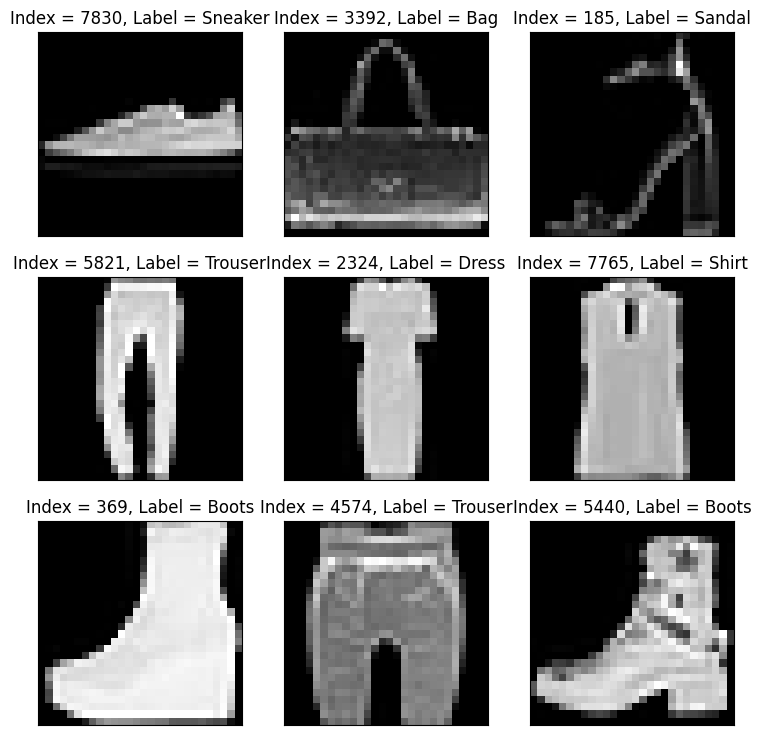

In [8]:
# Display the Data

PlotMnistImages(mXTrain, vYTrain, numImg, lClasses = L_CLASSES)

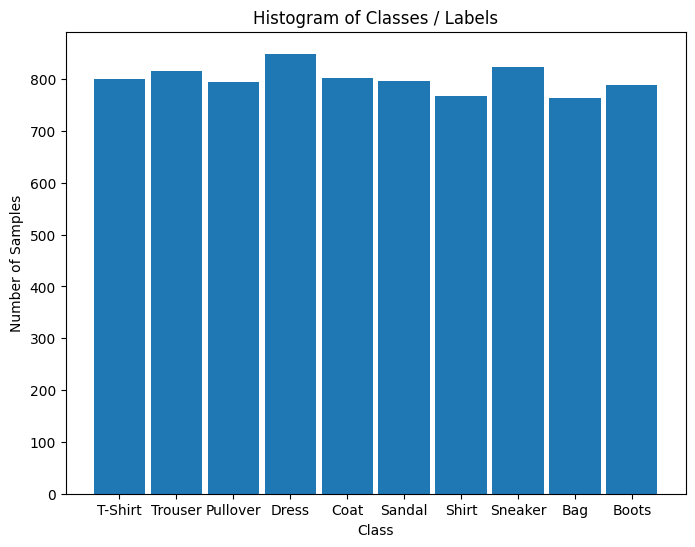

In [9]:
# Histogram of Classes
hA = PlotLabelsHistogram(vYTrain)
hA.set_xticks(range(len(L_CLASSES)))
hA.set_xticklabels(L_CLASSES)
plt.show()

## Train Linear SVM Classifier

This will be the base line

In [13]:
# SVM Linear Model
oSVM  = SVC(C = paramC, kernel = kernelType).fit(mXTrain, vYTrain) #<! We can do the training in a one liner
modelScore = oSVM.score(mXTest, vYTest)

print(f'The model score (Accuracy) on the data: {modelScore:0.2%}') #<! Accuracy

The model score (Accuracy) on the data: 79.15%


## Train Kernel SVM

In this section we'll train a Kernel SVM. We'll find the optimal kernel by cross validation.

In [ ]:
# Grid of the data support
v0       = np.linspace(mX[:, 0].min(), mX[:, 0].max(), numGridPts)
v1       = np.linspace(mX[:, 1].min(), mX[:, 1].max(), numGridPts)
XX0, XX1 = np.meshgrid(v0, v1)
XX       = np.c_[XX0.ravel(), XX1.ravel()]

Z = oSVM.predict(XX)
Z = Z.reshape(XX0.shape)

plt.figure(figsize = FIG_SIZE_DEF)
plt.contourf(XX0, XX1, Z, colors = CLASS_COLOR, alpha = 0.3, levels = [-0.5, 0.5, 1.5])
plt.scatter(mX[vIdx0, 0], mX[vIdx0, 1], s = ELM_SIZE_DEF, c = CLASS_COLOR[0], edgecolor = EDGE_COLOR)
plt.scatter(mX[vIdx1, 0], mX[vIdx1, 1], s = ELM_SIZE_DEF, c = CLASS_COLOR[1], edgecolor = EDGE_COLOR)
plt.show()

## Performance Metrics / Scores

Metrics / Scores are not limited as the loss of the model.  
They should reflect the real world needs according to the problem to solve and not the calculation limitations.

* <font color='brown'>(**#**)</font> While in the course we introduce the _classic_ metrics. In practice use what makes sense.

### Display the Confusion Matrix

In [ ]:
# Plot the Confusion Matrix

PlotConfusionMatrix(vY, oSVM.predict(mX), lLabels = oSVM.classes_)
plt.show()

### Compute the Scores: Precision, Recall and F1

In [ ]:
# Calculating the Scores
vHatY                    = oSVM.predict(mX)
precision, recall, f1, _ = precision_recall_fscore_support(vY, vHatY, pos_label = 1, average = 'binary')

print(f'Precision = {precision:0.3f}')
print(f'Recall    = {recall:0.3f}'   )
print(f'f1        = {f1:0.3f}'       )

### Balanced Accuracy

In [ ]:
# Balanced Accuracy: Average of TPR (Recall / Sensitivity) and TNR (Specificity)
_, specificity, _, _   = precision_recall_fscore_support(vY, vHatY, pos_label = 0, average = 'binary') #<! Pay attention to the definition of `pos_label`

bAcc = 0.5 * (recall + specificity)

print(f'Accuracy          = {modelScore:0.2%}'  )
print(f'Balanced Accuracy = {bAcc:0.2%}')

### ROC and AUC

In [ ]:
# Calculating the AUC
vScore         = oSVM.decision_function(mX) #<! Values proportional to distance from the separating hyperplane
vFP, vTP, vThr = roc_curve(vY, vScore, pos_label = 1)
AUC            = auc(vFP, vTP)

print(f'AUC = {AUC}')

In [ ]:
# Plotting the ROC

plt.figure(figsize = (16, 8))

plt.subplot(1, 2, 1)
plt.plot(vFP, vTP, color = 'b', lw = 2, label = f'ROC Curve, AUC = {AUC:.3f}')
plt.plot([0, 1], [0, 1], color = 'k', lw = 2, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.contourf(XX0, XX1, Z, colors = CLASS_COLOR, alpha = 0.3, levels = [-0.5, 0.5, 1.5])
plt.scatter(mX[vIdx0, 0], mX[vIdx0, 1], s = ELM_SIZE_DEF, c = CLASS_COLOR[0], edgecolor = EDGE_COLOR)
plt.scatter(mX[vIdx1, 0], mX[vIdx1, 1], s = ELM_SIZE_DEF, c = CLASS_COLOR[1], edgecolor = EDGE_COLOR)

plt.show()

In [ ]:
vScore = oSVM.decision_function(XX)
mScore = vScore.reshape(XX0.shape)

def PlotRoc(idx):
    _, vAx = plt.subplots(1, 2, figsize = (14, 6))
    hA = vAx[0]
    hA.plot(vFP, vTP, color = 'b', lw = 3, label = f'AUC = {AUC:.3f}')
    hA.plot([0, 1], [0, 1], color = 'k', lw = 2, linestyle = '--')
    hA.axvline(x = vFP[idx], color = 'g', lw = 2, linestyle = '--')
    hA.set_xlabel('False Positive Rate')
    hA.set_ylabel('True Positive Rate')
    hA.set_title ('ROC' f'\n$\\alpha = {vThr[idx]}$')
    hA.axis('equal')
    hA.legend()
    hA.grid()    
    
    Z  = mScore > vThr[idx]
    hA = vAx[1]
    hA.contourf(XX0, XX1, Z, colors = CLASS_COLOR, alpha = 0.3, levels = [0, 0.5, 1.0])
    hA.scatter(mX[vIdx0, 0], mX[vIdx0, 1], s = ELM_SIZE_DEF, c = CLASS_COLOR[0], edgecolor = EDGE_COLOR)
    hA.scatter(mX[vIdx1, 0], mX[vIdx1, 1], s = ELM_SIZE_DEF, c = CLASS_COLOR[1], edgecolor = EDGE_COLOR)

    plt.show()
    


In [ ]:
idxSlider = IntSlider(min = 0, max = len(vThr) - 1, step = 1, value = 0, layout = Layout(width = '30%'))
interact(PlotRoc, idx = idxSlider)

plt.show()

### Understanding the AUC

The AUC of a classifier is equal to the probability that the classifier will rank a randomly chosen positive example higher than a randomly chosen negative example:

$$ P\Big(\text{score}(x^+) > \text{score}(x^-)\Big) $$

In [ ]:
vYRoc = np.array(['P', 'P', 'N', 'P', 'P' , 'P' , 'N' , 'N' , 'P' , 'N' , 'P' , 'N' , 'P' , 'N' , 'N' , 'N' , 'P' , 'N' , 'P' , 'N'])
vSRoc = np.array([0.9, 0.8, 0.9, 0.6, 0.55, 0.51, 0.49, 0.43, 0.22, 0.39, 0.13, 0.31, 0.23, 0.22, 0.19, 0.15, 0.12, 0.11, 0.04, 0.01]) #<! Score values (Probability for Class 1)

vYRoc = np.where(vYRoc == 'P', 1, 0) #<! Labels


In [ ]:
vFPRoc, vTPRoc, vThrRoc = roc_curve(vYRoc, vSRoc, pos_label = 1)
aucRoc                  = auc(vFPRoc, vTPRoc)
print(f'AUC = {aucRoc}')

In [ ]:
plt.figure(figsize = (8, 8))

plt.plot(vFPRoc, vTPRoc, color = 'b', lw = 2, label = f'ROC Curve, AUC = {aucRoc:.3f}')
plt.plot([0, 1], [0, 1], color = 'k', lw = 2, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.grid()
plt.legend()

plt.show()


In [ ]:
vIdx0Roc = vYRoc == 0
vIdx1Roc = vYRoc == 1

# Empirical AUC
empAuc = np.mean(np.random.choice(vSRoc[vIdx1Roc], 1000) > np.random.choice(vSRoc[vIdx0Roc], 1000))
print(f'Empirical AUC: {empAuc}')

In [ ]:
vYEstRoc = vSRoc > 0.5
vYEstRoc = vYEstRoc.astype(np.int32)

In [ ]:
# Balanced Accuracy: Mean of TPR (Recall / Sensitivity) and TNR (Specificity)
precisionRoc, recallRoc, f1Roc, _   = precision_recall_fscore_support(vYRoc, vYEstRoc, pos_label = 1, average = 'binary')
tnRoc, fpRoc, fnRoc, tpRoc          = confusion_matrix(vYRoc, vYEstRoc).ravel() #<! Another way to access all measures
specificityRoc = tnRoc / (tnRoc + fpRoc)
0.5 * (recallRoc + specificityRoc)

In [ ]:
# The AUC and Accuracy are not equivalent!
empAccu = np.mean(vYEstRoc == vYRoc)
print(f'Empirical Accuracy: {empAccu}')